# Modelo de Machine Learning para Tasa de Autorización (Agrupado)

Iniciando búsqueda de hiperparámetros...
Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\jose.valdez\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:23:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Mejores parámetros encontrados:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Reporte de clasificación:
              precision    recall  f1-score   support

        ALTA       0.85      0.88      0.87       534
        BAJA       0.81      0.87      0.84       534
       MEDIA       0.79      0.70      0.74       534

    accuracy                           0.82      1602
   macro avg       0.82      0.82      0.82      1602
weighted avg       0.82      0.82      0.82      1602



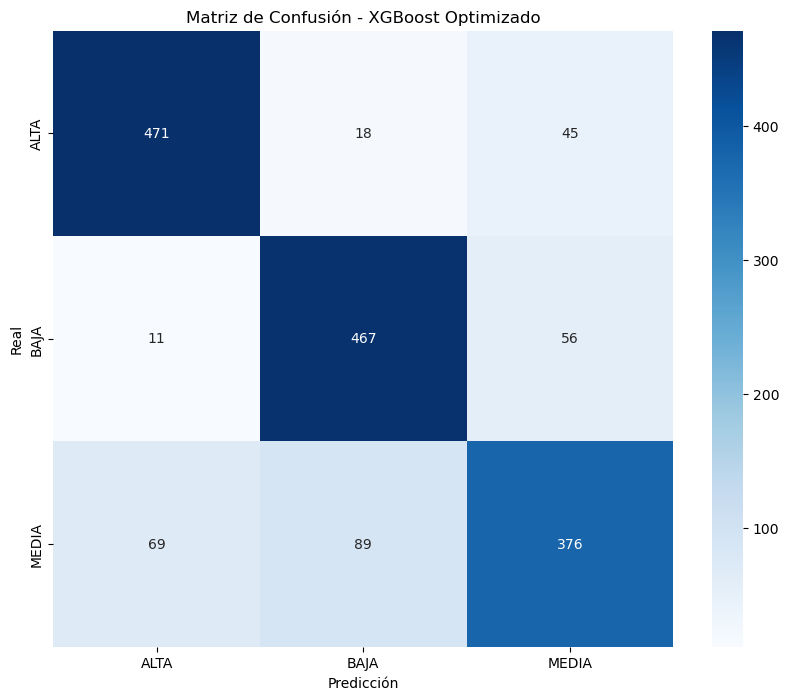

C:\Users\jose.valdez\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\jose.valdez\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\jose.valdez\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:23:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\jose.valdez\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:23:26] WARNING: C:\actions-runner\_work\xgbo


Validación cruzada con el mejor modelo:
Precisión promedio: 0.840 (+/- 0.017)
F1-score promedio: 0.837 (+/- 0.017)


C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_9788\3510846599.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias_df.head(20), palette="viridis")


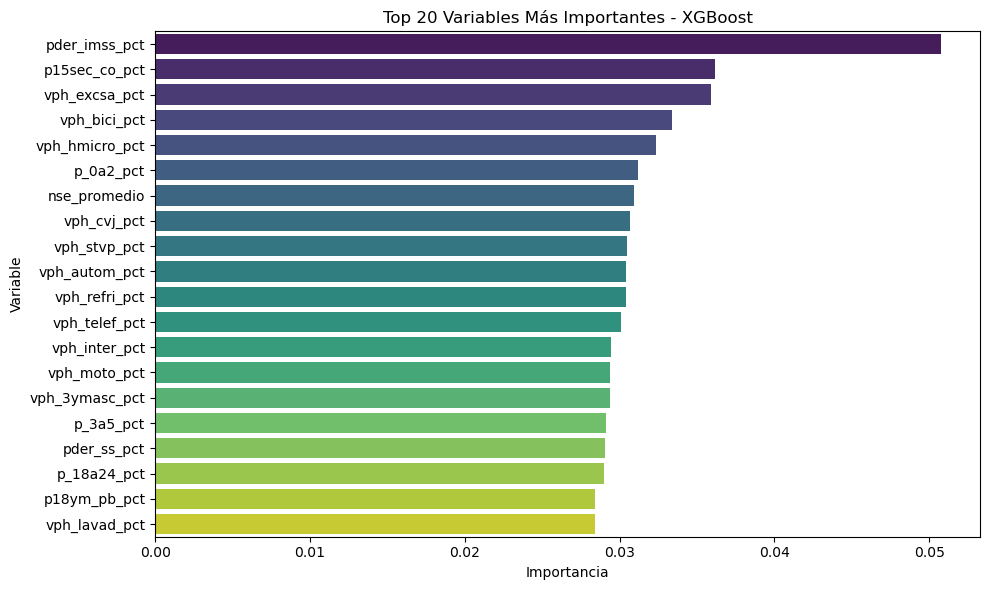


Importancia de variables:
          Variable  Importancia
20   pder_imss_pct     0.050747
22   p15sec_co_pct     0.036150
0    vph_excsa_pct     0.035879
12    vph_bici_pct     0.033395
14  vph_hmicro_pct     0.032360
23       p_0a2_pct     0.031196
33    nse_promedio     0.030914
9      vph_cvj_pct     0.030701
7     vph_stvp_pct     0.030498
1    vph_autom_pct     0.030443
15   vph_refri_pct     0.030410
16   vph_telef_pct     0.030120
2    vph_inter_pct     0.029443
11    vph_moto_pct     0.029368
6   vph_3ymasc_pct     0.029355
24       p_3a5_pct     0.029155
4      pder_ss_pct     0.029081
28     p_18a24_pct     0.028993
5     p18ym_pb_pct     0.028415
13   vph_lavad_pct     0.028414

Modelo guardado en: modelo_xgboost_optimizado.pkl
Label encoder guardado en: label_encoder.pkl
Umbral óptimo para clase 'ALTA': 0.411
Umbral óptimo para clase 'BAJA': 0.628
Umbral óptimo para clase 'MEDIA': 0.317


In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os
import multiprocessing  # <- Nuevo import

# Configura para usar todos los núcleos físicos (o menos si quieres dejar recursos libres)
n_cores = multiprocessing.cpu_count()  # Usará 20 en tu caso
os.environ['LOKY_MAX_CPU_COUNT'] = '16'  # Configura todos los núcleos

# os.environ['LOKY_MAX_CPU_COUNT'] = '16'
# Leer el archivo csv
file_name = "./Datasets/Dataset-Entrenamiento.csv"
df = pd.read_csv(file_name, encoding='latin-1', low_memory=False)

# Función para limpiar y convertir columnas a numérico
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# Limpiar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace('\n', ' ')

# Columnas para agrupar (localidad / manzana)
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'nombre']
columnas_grupo = [col for col in columnas_grupo if col in df.columns]

# Variables que se deben sumar antes de calcular porcentaje
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

# Limpiar y convertir las variables antes de sumar
for var in variables_a_sumar:
    if var in df.columns:
        df[var] = limpiar_y_convertir(df[var])

# Sumar variables por localidad
df_sums = df.groupby(columnas_grupo)[variables_a_sumar].sum().reset_index()

# Sumar variables totales para denominadores
df_totales = df.groupby(columnas_grupo).agg({
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum'
}).reset_index().rename(columns={
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum'
})

# Unir sumas y totales
df_totales = pd.merge(df_sums, df_totales, on=columnas_grupo)

# Calcular porcentajes con base en totales agrupados
for var in variables_a_sumar:
    if var not in df_totales.columns:
        continue
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_activa_sum']
    elif var in ['pder_ss', 'p_0a2', 'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24',
                 'pob15_64', 'p_60ymas', 'p12ym_casa', 'p12ym_solt']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_total_sum']
    else:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['total_viviendas_sum']

# Agregar promedio numérico de NSE por localidad si existe la columna 'nse'
if 'nse' in df.columns:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df['nse'] = pd.Categorical(df['nse'], categories=orden_clases, ordered=True)
    df['nse_num'] = df['nse'].cat.codes
    df_nse_prom = df.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom = df_nse_prom.rename(columns={'nse_num': 'nse_promedio'})
    df_totales = pd.merge(df_totales, df_nse_prom, on=columnas_grupo, how='left')

# Seleccionar variables para modelo: usar solo las variables porcentuales y 'nse_promedio' si existe
variables_pct = [col for col in df_totales.columns if col.endswith('_pct')]
if 'nse_promedio' in df_totales.columns:
    variables_pct.append('nse_promedio')

# El target 'clasificacion' debe estar en df (agrupar si es necesario)
if 'clasificacion' not in df.columns:
    raise ValueError("La columna 'clasificacion' no está en el dataset original.")
# Agrupar clasificación por localidad (mayoría o modo)
df_clasificacion = df.groupby(columnas_grupo)['clasificacion'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()

# Unir con df_totales
df_model = pd.merge(df_totales, df_clasificacion, on=columnas_grupo, how='left')

# Eliminar filas sin clasificación
df_model = df_model.dropna(subset=['clasificacion'])

# Preparar datos para modelo
X = df_model[variables_pct].copy()
y = df_model['clasificacion'].astype('category')

# Reemplazar inf y NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Balancear clases con SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Configuración inicial de XGBoost con parámetros conservadores para evitar overfitting
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Parámetros para la búsqueda en grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Métrica de evaluación (F1 weighted)
scorer = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=1
)

print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_xgb = grid_search.best_estimator_

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Predecir y evaluar
y_pred = best_xgb.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - XGBoost Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Validación cruzada con el mejor modelo
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_accuracy = cross_val_score(best_xgb, X_resampled, y_resampled, cv=skf, scoring='accuracy')
scores_f1 = cross_val_score(best_xgb, X_resampled, y_resampled, cv=skf, scoring='f1_weighted')

print("\nValidación cruzada con el mejor modelo:")
print(f"Precisión promedio: {scores_accuracy.mean():.3f} (+/- {scores_accuracy.std() * 2:.3f})")
print(f"F1-score promedio: {scores_f1.mean():.3f} (+/- {scores_f1.std() * 2:.3f})")

# Importancia de variables
importancias = best_xgb.feature_importances_
importancias_df = pd.DataFrame({'Variable': variables_pct, 'Importancia': importancias}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importancias_df.head(20), palette="viridis")
plt.title("Top 20 Variables Más Importantes - XGBoost")
plt.tight_layout()
plt.show()

print("\nImportancia de variables:")
print(importancias_df.head(20))

# Guardar modelo
modelo_path = "modelo_xgboost_optimizado.pkl"
joblib.dump(best_xgb, modelo_path)
print(f"\nModelo guardado en: {modelo_path}")

# Guardar el label encoder también
encoder_path = "label_encoder.pkl"
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder guardado en: {encoder_path}")


from sklearn.metrics import precision_recall_curve

# Obtener las etiquetas verdaderas (y_true) y las probabilidades (y_scores) del conjunto de validación
# (Asume que tienes X_test, y_test del train-test split)
y_scores = xgb_model.predict_proba(X_test)  # Probabilidades para cada clase
y_true = y_test  # Etiquetas codificadas numéricamente

# Diccionario para almacenar umbrales óptimos por clase
umbrales_optimos = {}

# Calcular umbral óptimo para cada clase
for i, clase in enumerate(label_encoder.classes_):
    precision, recall, thresholds = precision_recall_curve(
        (y_true == i).astype(int),  # Máscara para la clase actual
        y_scores[:, i]               # Probabilidades de la clase actual
    )
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    umbral_optimo = thresholds[np.argmax(f1_scores)]
    umbrales_optimos[clase] = umbral_optimo
    print(f"Umbral óptimo para clase '{clase}': {umbral_optimo:.3f}")


### Modelo Aplicado a Municipio

In [22]:
import pandas as pd
import numpy as np
import joblib
import multiprocessing
import os

# Configurar núcleos
n_cores = multiprocessing.cpu_count()
os.environ['LOKY_MAX_CPU_COUNT'] = '16'

# 1. Cargar modelo y label encoder
modelo_path = 'modelo_xgboost_optimizado.pkl'
rf_model = joblib.load(modelo_path)
label_encoder = joblib.load('label_encoder.pkl')
print("Modelo y LabelEncoder cargados exitosamente")

# 2. Cargar y preparar nuevos datos
df_nuevo = pd.read_csv("./Datasets/07.NSE.csv")

munis = [
    # Lista nueva
    'Encarnación de Díaz',
    'Manuel Doblado',
    'Silao de la victoria',
    'Lagos de Moreno',
    'Romita',
    'Guanajuato',
    'Jalostotitlán',
    'San Francisco del Rincón',
    'Jerécuaro',
    'Celaya',
    'Irapuato',
    'Salamanca',
    'Pénjamo',
    'Abasolo',
    'La Piedad',
    'Yurécuaro',
    'Santa Cruz de Juventino Rosas',
    'Villagrán',
    'Atlacomulco',
    'Atitalaquia',
    'Acambay de Ruíz Castañeda',
    'Temascalcingo',
    'Tula de Allende',
    'Almoloya de Juárez',
    'Jilotepec',
    'Tianguistenco',
    'San Juan del Río',
    'Apaseo el Grande',
    'Comonfort',
    'Tequisquiapan',
    'San Miguel de Allende',
    'Tecozautla',
    'Ezequiel Montes',
    'Colón',
    'Amealco de Bonfil',
    'Apaseo el Alto',
    'San Francisco de los Romo',
    'Villa Hidalgo',
    'Jalpa',
    'Jerez',
    'Ojocaliente',
    'Loreto',
    'Zacatecas',
    'Jesús María',
    'Pabellón de Arteaga',
    'San Luis Potosí',
    'Dolores Hidalgo Cuna de la Independencia Nacional',
    'San Felipe',
    'San Luis de la Paz',
    'San José Iturbide',
    'Santa María del Río',
    'Villa de Reyes',
    'Ojuelos de Jalisco',
    'San Diego de la Unión'
]
munis_upper = [m.upper() for m in munis]
munis_existentes = df_nuevo['nom_mun'].str.upper().unique()
faltantes = [m for m in munis_upper if m not in munis_existentes]
if faltantes:
    raise ValueError(f"Los siguientes municipios no existen en el DataFrame: {faltantes}")

df_ags = df_nuevo[df_nuevo['nom_mun'].str.upper().isin(munis_upper)].copy()

# 3. Función de limpieza
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# 4. Columnas para agrupar
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'NOMBRE', 'CVEID_ENTI']
columnas_grupo = [col for col in columnas_grupo if col in df_ags.columns]

# 5. Variables a sumar
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]
for var in variables_a_sumar:
    if var in df_ags.columns:
        df_ags[var] = limpiar_y_convertir(df_ags[var])

# 6. Sumar por localidad
df_sums = df_ags.groupby(columnas_grupo)[variables_a_sumar].sum().reset_index()
# Primero limpiamos las columnas numéricas
for col in ['tvivparhab', 'pea', 'pobtot']:
    if col in df_ags.columns:
        df_ags[col] = limpiar_y_convertir(df_ags[col])
# 7. Totales
df_totales = df_ags.groupby(columnas_grupo).agg({
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum'
}).reset_index().rename(columns={
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum'
})

# 8. Unir sumas y totales
df_totales = pd.merge(df_sums, df_totales, on=columnas_grupo)

# Limpiar columnas totales
df_totales['total_viviendas_sum'] = pd.to_numeric(df_totales['total_viviendas_sum'].astype(str).str.replace('*','',regex=False), errors='coerce')
df_totales['poblacion_activa_sum'] = pd.to_numeric(df_totales['poblacion_activa_sum'].astype(str).str.replace('*','',regex=False), errors='coerce')
df_totales['poblacion_total_sum'] = pd.to_numeric(df_totales['poblacion_total_sum'], errors='coerce')

# 9. Calcular porcentajes
for var in variables_a_sumar:
    if var not in df_totales.columns:
        continue
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['poblacion_activa_sum'].replace(0, np.nan)
    elif var in ['pder_ss','p_0a2','p_3a5','p_6a11','p_12a14','p_15a17','p_18a24',
                 'pob15_64','p_60ymas','p12ym_casa','p12ym_solt']:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['poblacion_total_sum'].replace(0, np.nan)
    else:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['total_viviendas_sum'].replace(0, np.nan)

# 10. NSE promedio
if 'nse' in df_ags.columns and 'nse_promedio' in rf_model.feature_names_in_:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df_ags['nse'] = pd.Categorical(df_ags['nse'], categories=orden_clases, ordered=True)
    df_ags['nse_num'] = df_ags['nse'].cat.codes
    df_nse_prom = df_ags.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom.rename(columns={'nse_num':'nse_promedio'}, inplace=True)
    df_totales = pd.merge(df_totales, df_nse_prom, on=columnas_grupo, how='left')

# 11. Variables para modelo
variables_pct = [col for col in df_totales.columns if col.endswith('_pct')]
if 'nse_promedio' in df_totales.columns and 'nse_promedio' in rf_model.feature_names_in_:
    variables_pct.append('nse_promedio')

# 12. Completar variables faltantes
missing_vars = set(rf_model.feature_names_in_) - set(variables_pct)
for var in missing_vars:
    if var not in df_totales.columns:
        df_totales[var] = np.nan

# Orden correcto
X_ags = df_totales[rf_model.feature_names_in_].copy()

# 13. Limpieza final
X_ags.replace([np.inf, -np.inf], np.nan, inplace=True)
X_ags.fillna(X_ags.median(), inplace=True)

# 14. Predecir probabilidades
probabilidades = rf_model.predict_proba(X_ags)
clases_numericas = rf_model.classes_
clases = label_encoder.inverse_transform(clases_numericas)

# 15. Crear DataFrame resultados
resultados = df_totales[columnas_grupo].copy()
for i, clase in enumerate(clases):
    resultados[f'prob_{clase}'] = probabilidades[:, i]

# Clasificación más probable
resultados['clasificacion_predicha'] = label_encoder.inverse_transform(np.argmax(probabilidades, axis=1))
resultados['prob_maxima'] = np.max(probabilidades, axis=1)

# 16. Columnas de salida
columnas_output = columnas_grupo + [f'prob_{clase}' for clase in clases] + ['clasificacion_predicha','prob_maxima']
df_final = resultados[columnas_output]

# Mostrar y guardar
print("\nMuestra de resultados:")
print(df_final.head())

output_path = r"./Predicciones/tasa-de-autorizacion-por-municipio.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_final.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\nResultados guardados en: {output_path}")


Modelo y LabelEncoder cargados exitosamente


C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_9788\2533599627.py:18: DtypeWarning: Columns (6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,233,237,243,244,245,247,252) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nuevo 


Muestra de resultados:
          nom_ent      nom_mun                                  nom_loc  \
0  Aguascalientes  Jesús María  Arboledas Paso Blanco [Fraccionamiento]   
1  Aguascalientes  Jesús María  Arboledas Paso Blanco [Fraccionamiento]   
2  Aguascalientes  Jesús María  Arboledas Paso Blanco [Fraccionamiento]   
3  Aguascalientes  Jesús María  Arboledas Paso Blanco [Fraccionamiento]   
4  Aguascalientes  Jesús María  Arboledas Paso Blanco [Fraccionamiento]   

                              NOMBRE CVEID_ENTI  prob_ALTA  prob_BAJA  \
0              ARBOLEDAS PASO BLANCO      722-1   0.017559   0.023852   
1  ARBOLEDAS PASO BLANCO 2DA SECCION      837-1   0.050352   0.116163   
2                         CAMPO REAL      825-1   0.109000   0.228635   
3             JARDINES DE CAMPO REAL      888-1   0.029285   0.018853   
4      VIÃ‘EDOS EVA (FRACC PASO BCO)      836-1   0.419023   0.191644   

   prob_MEDIA clasificacion_predicha  prob_maxima  
0    0.958590                  MED